In [1]:
%pwd

'C:\\Users\\armando_borjas\\Documents\\Python'

In [1]:
import pandas as pd
import pyodbc
import pandas_profiling
import cx_Oracle
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)
pd.set_option('display.width', 10000)
pd.set_option('display.expand_frame_repr',True)
plt.rcParams["figure.figsize"]=20,20

# setting up database connection strings

In [2]:
##SQL SERVER SETUP
# driver = '{SQL Server Native Client 11.0}'
# server = 'sql2017'
# db = 'dras_irasv6_training'
# conn = pyodbc.connect("Driver="+driver+";Server="+server+";Database="+db+";Trusted_Connection=yes;")

##ORACLE SERVER SETUP
# ip = 'ORA12C' #use the name of the server
# port = '1521' #default is 1521
# SID = 'ORA12C'#not too sure about this one
# dsn_tns = cx_Oracle.makedsn(ip, port, SID)

# conn = cx_Oracle.connect(user=r'ATCO_IRASV5_STAGE', password='atco', dsn='ORA12C')

# q0 = """select ld.code , c.* from coating c
#         join listdomain ld on c.coatinglinedomainid = ld.id"""

# q1 = """select ps.* from pipesegment ps"""

# q2 = """select maop.* from maop maop"""

# q3 = """select * from pipesegment ps
#         inner join stationseries ss on ps.beginstationseriesid = ss.id
#         inner join maop on maop.beginstationseriesid = ss.id"""
# df1 = pd.read_sql_query(q1,conn)
# maop = pd.read_sql_query(q2,conn)
# data = pd.read_sql_query(q3,conn)

def oracle_sql(q,user=r'ug_irasv6_gtech_poe_stage', password='ug', dsn='ORA12C'):
    conn = cx_Oracle.connect(user, password, dsn)

    t_data = pd.read_sql_query(q,conn)

    conn.close()
    
    return t_data

def sqlserver_sql(q, server = 'SQL2012', db = 'EEC_US_TRANS_IRASV6_STAGE'):
    driver = '{SQL Server Native Client 11.0}'
    conn = pyodbc.connect("Driver="+driver+";Server="+server+";Database="+db+";Trusted_Connection=yes;")

    # performing query to database
    df = pd.read_sql_query(q,conn)

    conn.close()
    return df

In [5]:
q1 = """select * from MonteCarloPOE poe"""
q2 = """select * from MonteCarloPOECalc poe"""
q3 = """select * from MonteCarloPOEYear poe"""

q4 = """select * from global_name"""

oracle_sql(q4)#.to_csv('MonteCarloPOEYear.csv')#.describe(include='all')

,GLOBAL_NAME
0,ORA12C.CGY.DYNAMICRISK.NET


In [39]:
q = """select * from user_views"""
oracle_sql(q).loc[lambda x: x.VIEW_NAME.str.contains('wrinkle', case=False)]

# q = """select * from v_IRAS"""
# oracle_sql(q)

,VIEW_NAME,TEXT_LENGTH,TEXT,TEXT_VC,TYPE_TEXT_LENGTH,TYPE_TEXT,OID_TEXT_LENGTH,OID_TEXT,VIEW_TYPE_OWNER,VIEW_TYPE,SUPERVIEW_NAME,EDITIONING_VIEW,READ_ONLY,CONTAINER_DATA,BEQUEATH,ORIGIN_CON_ID
111,V_IRAS_WRINKLEBEND,3167,"SELECT ER.event_id AS Id,\n ER.effect...","SELECT ER.event_id AS Id,\n ER.effect...",None,None,None,None,None,None,None,N,N,N,DEFINER,0


# ensuring records are sorted in ascending BeginStationSeriesID and ascending BeginStationNum

In [3]:
df1 = df1.sort_values(by=['BeginStationSeriesId','BeginStationNum']).reset_index(drop=True)

NameError: name 'df1' is not defined

# creating subset of full query pertaining to only the StationSeries extents 

In [ ]:
coating_df = df1[['BeginStationSeriesId','BeginStationNum','EndStationSeriesId','EndStationNum']]
coating_df.head()

# the following Pandas groupby will:
    # 1. Group the dataframe based on BeginStationSeriesId and EndStationSeriesId
    # 2. Apply a calculation to subtract the current record EndStationNum from the next BeginStationNum
    # Improvement might be to convert this to chainage, group by lineloopID, and repeat this with chaingages instead
    # Another improvement might be to also gather MLVCorrection records, or StationSeries records, and also check that the observed data covers entire pipeline

In [ ]:
coating_df.groupby(['BeginStationSeriesId','EndStationSeriesId']).apply(lambda x: x['BeginStationNum'].shift(-1)-x['EndStationNum'])

# following statement collapses grouped dataset into dataframe, and filters for any record differences NOT EQUAL TO 0.0

In [ ]:
coating_df_overlaps = coating_df.groupby(['BeginStationSeriesId','EndStationSeriesId']).apply(lambda x: x['BeginStationNum'].shift(-1)-x['EndStationNum']).reset_index(name='record_diff')
coating_df_overlaps.query('record_diff!=0.')

# from line above, records #36 and #37, belonging to BSSID 1 seem to contain gaps

In [ ]:
coating_df[coating_df['BeginStationSeriesId']==1]

# Replicating same exercise above, but this time doing it with MLVCorrection, and converting the linear table's StationNums into chainages

In [ ]:
df2 = pd.read_sql_query("""select ld.code [coating type],
                            (mlv1.MultiplierNum*c.BeginStationNum+mlv1.FactorNum) [cBeginChainage],
                            (mlv2.MultiplierNum*c.EndStationNum+mlv2.FactorNum) [cEndChainage], c.* from coating c
                            join listdomain ld on c.coatinglinedomainid = ld.id
                            join MlvCorrection mlv1 on mlv1.StationSeriesId = c.BeginstationSeriesId
                            join MlVcorrection mlv2 on mlv2.StationseriesId = c.EndStationSeriesId""",conn)
len(df2)

In [ ]:
df2 = df2.sort_values(by=['BeginStationSeriesId','cBeginChainage']).reset_index(drop=True)
df2.head()

In [ ]:
cdf2 = df2[['BeginStationSeriesId','cBeginChainage','EndStationSeriesId','cEndChainage']]
cdf2.head()

In [ ]:
cdf2.groupby(['BeginStationSeriesId','EndStationSeriesId']).apply(lambda x: x['cBeginChainage'].shift(-1)-x['cEndChainage'])

In [ ]:
cdf2_overlaps = cdf2.groupby(['BeginStationSeriesId','EndStationSeriesId']).apply(lambda x: x['cBeginChainage'].shift(-1)-x['cEndChainage']).reset_index(name='record_diff')
cdf2_overlaps.query('record_diff!=0.')

In [ ]:
cdf2[cdf2['BeginStationSeriesId']==1].iloc[36:38,:]

In [ ]:
cdf2_overlaps.query('BeginStationSeriesId==1')

In [ ]:
from ggplot import *
df1.head()

In [ ]:
p = ggplot(df1, aes(x='coating type')) + \
        geom_bar(stat = 'count') + theme(axis_text_x = element_text(angle = 90))
p

# Additional analysis on ORACLE database 

In [ ]:
df1.count()

In [ ]:
maop.count()

In [279]:
ps_t.assign(corr_all=ps_t.PIPEWALLTHICKNESS-((ps_t.PIPEOUTSIDEDIAMETER*25.4*ps_t.MAXALLOWABLEPRESSURE)/(2000*ps_t.PIPEGRADE))).loc[:,['corr_all']].query("corr_all > 0").hist(bins=20)

AttributeError: 'DataFrame' object has no attribute 'MAXALLOWABLEPRESSURE'

In [ ]:
query_s = """select ld.code, c.* from coating c
            inner join listdomain ld on c.coatinglinedomainid = ld.id"""

# oracle_sql(q).groupby('CODE').count().ID.plot(kind='bar')
((datetime.datetime.now() - oracle_sql(query_s).EFFECTIVESTARTDATE).dt.days/365.25).hist(bins=50)

In [ ]:
import datetime
((datetime.datetime.now() - df1.EFFECTIVESTARTDATE).dt.days/365.25).hist(bins=50)

In [ ]:
query_s = """select ll.id, sum(abs(ss.endstationnum-ss.beginstationnum))/1000 as llength from stationseries ss
            inner join lineloop ll on ss.lineloopid = ll.id
            group by ll.id
            order by llength asc"""

oracle_sql(query_s).assign(FF_1 = lambda x: 1.0/(x.LLENGTH*10))
# oracle_sql(query_s).plot(kind='bar')

In [ ]:
query_s = """select cpr.* from cpsurveyrange cpr
            """

oracle_sql(query_s)#.assign(FF_1 = lambda x: 1.0/(x.LLENGTH*10))
# oracle_sql(query_s).plot(kind='bar')c

In [277]:
query_ss = """select ss.* from stationseries ss
            """
query_ps = """select ps.* from pipesegment ps
            """
query_maop = """select maop.* from maop maop
            """

ss_t = oracle_sql(query_ss)
ps_t = oracle_sql(query_ps)
maop_t = oracle_sql(query_maop)

In [ ]:
ss_t

In [273]:
smys_t = ss_t.merge(ps_t, how="inner",left_on='ID',right_on='BEGINSTATIONSERIESID',suffixes=('_SS','_PS')).merge(maop_t, left_on='ID_SS', right_on='BEGINSTATIONSERIESID',suffixes=('','_MAOP'))

In [274]:
smys_t.loc[:,['ID_SS','PIPEOUTSIDEDIAMETER','PIPEWALLTHICKNESS','PIPEGRADE','MAXALLOWABLEPRESSURE']].dropna().assign(PCT_SMYS  = lambda x: (x.MAXALLOWABLEPRESSURE*x.PIPEOUTSIDEDIAMETER*25.4)/(20*x.PIPEWALLTHICKNESS*x.PIPEGRADE)).query("PCT_SMYS<100").loc[:,['PCT_SMYS']].describe()

,PCT_SMYS
count,630129.000000
mean,53.993903
std,17.986303
min,0.000000
25%,42.526959
50%,55.975778
75%,67.504595
max,96.064690


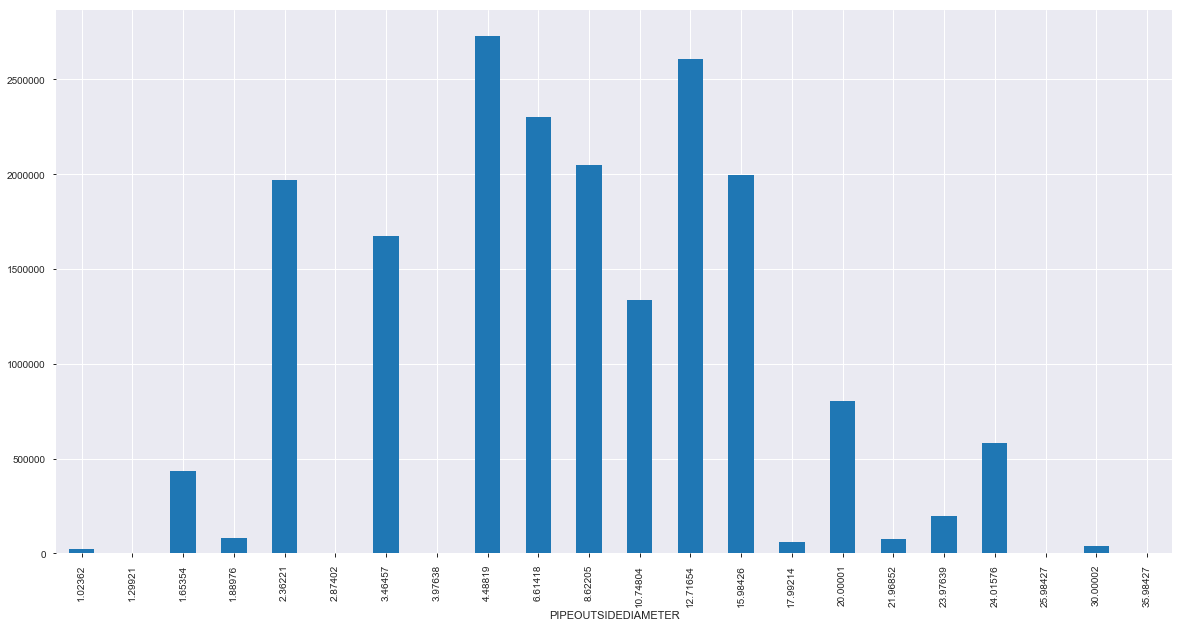

In [271]:
ps_t.loc[:,['PIPEOUTSIDEDIAMETER','BEGINSTATIONNUM','ENDSTATIONNUM']].assign(LENGTH = lambda x: x.ENDSTATIONNUM-x.BEGINSTATIONNUM).groupby('PIPEOUTSIDEDIAMETER').sum().LENGTH.plot(kind='bar')

In [ ]:
od_dist = ps_t.loc[:,['PIPEOUTSIDEDIAMETER','BEGINSTATIONNUM','ENDSTATIONNUM']].assign(LENGTH = lambda x: x.ENDSTATIONNUM-x.BEGINSTATIONNUM).groupby('PIPEOUTSIDEDIAMETER').sum()
od_dist

In [ ]:
od_b_wt = ps_t.loc[:,['PIPEOUTSIDEDIAMETER','PIPEWALLTHICKNESS','BEGINSTATIONNUM','ENDSTATIONNUM']].assign(ODbT=lambda x: round((x.PIPEOUTSIDEDIAMETER*25.4)/x.PIPEWALLTHICKNESS),
                                                                                                LENGTH = lambda x: abs(x.ENDSTATIONNUM-x.BEGINSTATIONNUM)/1000).groupby('ODbT').sum().LENGTH.plot(kind='bar')
# To specify the number of ticks on both or any single axes
# plt.locator_params(axis='y', nbins=6)
# plt.locator_params(axis='x', nbins=99)

In [269]:
import plotly
plotly.__version__

'4.1.1'

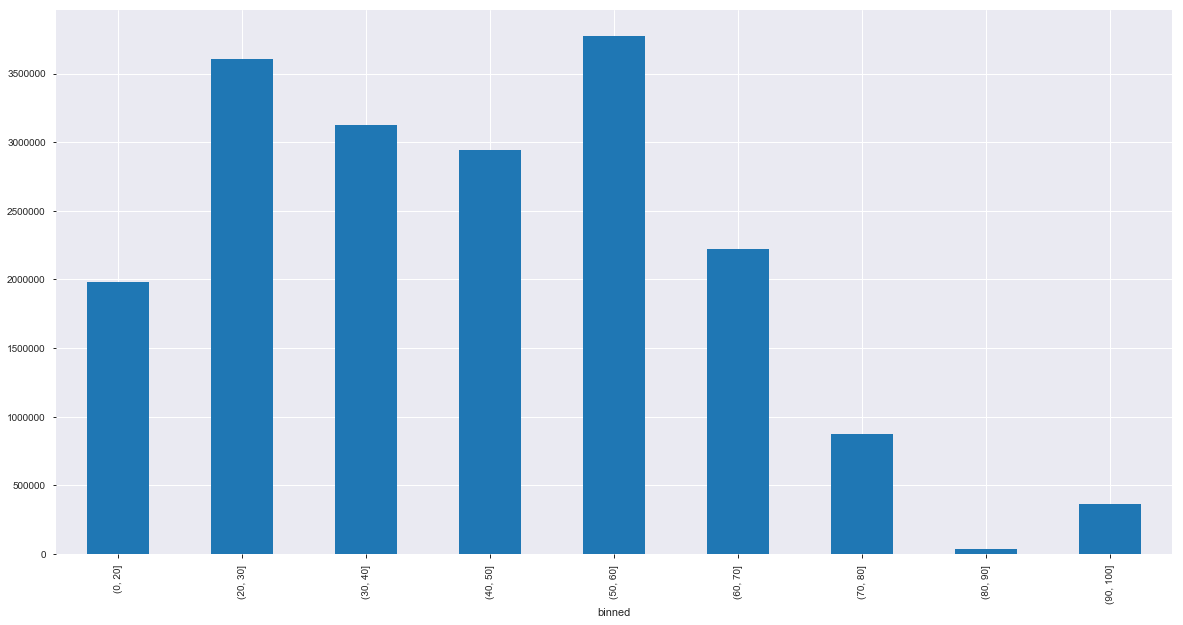

In [293]:
import plotly.graph_objs as go
import plotly.offline as pyo #import download_plotlyjs, init_notebook_mode, plot, iplot
pyo.init_notebook_mode(connected=True)

q1 = """select abs(ps.EndStationNum-ps.BeginstationNum) as LENGTH, round(ps.PIPEOUTSIDEDIAMETER*25.4/ps.PIPEWALLTHICKNESS,0) as ODbT  from pipesegment ps
            """

odbwt = oracle_sql(q1)
# pd.cut(odbwt.loc[lambda x: ~x.ODBT.isnull(),:].groupby('ODBT').sum().LENGTH, bins=[20, 30, 40, 50, 60, 70, 80, 90])
odbwt.loc[lambda x: ~x.ODBT.isnull(),:].assign(binned = pd.cut(odbwt.loc[lambda x: ~x.ODBT.isnull(),'ODBT'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90,100])).groupby('binned').sum().LENGTH.plot(kind='bar')

# trace1 = go.Bar(x = odbwt.loc[lambda x: ~x.ODBT.isnull(),:].groupby('ODBT').sum().index, y = odbwt.loc[lambda x: ~x.ODBT.isnull(),:].groupby('ODBT').sum().LENGTH/1000)

# traces = [trace1]

# pyo.iplot( {'data':traces} )


In [296]:
ps_t

q_man_dl = """select * from DomainCatalogColXRef dcx
                where dcx.Tablename = 'PipeSegment'
                """
q_man_dl2 = """select * from ListDomain ld
                where ld.DomainCatalogId = 8
                """
q_man_dl3 = """select * from HydroTestRange ht
                """
oracle_sql(q_man_dl)#.assign(LENGTH= lambda x: abs(x.ENDSTATIONNUM-x.BEGINSTATIONNUM)).LENGTH.sum()/1000

,DOMAINCATALOGID,TABLENAME,COLUMNNAME,LASTMODBYUSERID,LASTMODDATETIME
0,11,PipeSegment,PipeConstructSeasonDomainId,SYS,2018-04-19 14:20:13
1,10,PipeSegment,PipeGirthWeldDomainId,SYS,2018-04-19 14:20:13
2,12,PipeSegment,PipeInstallContractorDomainId,SYS,2018-04-19 14:20:13
3,5,PipeSegment,PipeManufacturerDomainId,SYS,2018-04-19 14:20:13
4,7,PipeSegment,PipeMaterialDomainId,SYS,2018-04-19 14:20:13
5,13,PipeSegment,PipeNDETTypeDomainId,SYS,2018-04-19 14:20:13
6,8,PipeSegment,PipeSeamDomainId,SYS,2018-04-19 14:20:13
7,9,PipeSegment,PipeSeamOrientationDomainId,SYS,2018-04-19 14:20:13
8,6,PipeSegment,PipeSpecificationDomainId,SYS,2018-04-19 14:20:13
9,348,PipeSegment,PipeSubtypeDomainId,SYS,2018-04-19 14:20:13


In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

f6 = """select sum(abs(ps.EndStationNum-ps.BeginstationNum)) as LENGTH, 
round(ps.PIPEOUTSIDEDIAMETER*25.4/ps.PIPEWALLTHICKNESS,0) as ODBT  
from pipesegment ps
group by round(ps.PIPEOUTSIDEDIAMETER*25.4/ps.PIPEWALLTHICKNESS,0)
            """
f6_odbwt = oracle_sql(f6)
  
#Set figure size with matplotlib
plt.figure(figsize=(20,12))
fig1 = px.bar(f6_odbwt, x='ODBT', y='LENGTH',
            hover_data=['ODBT', 'LENGTH'], color='ODBT'              
           )
fig1.show()

<Figure size 1440x864 with 0 Axes>

In [39]:
q_tpd_dl = """select ld.code as type, lu.* from landuse lu
                inner join listdomain ld on lu.LANDUSEDOMAINID = ld.id
                """
oracle_sql(q_tpd_dl).assign(LENGTH= lambda x: abs(x.ENDSTATIONNUM-x.BEGINSTATIONNUM))

,TYPE,ID,EFFECTIVESTARTDATE,EFFECTIVEENDDATE,LANDUSEDOMAINID,BEGINSTATIONSERIESID,BEGINSTATIONNUM,ENDSTATIONSERIESID,ENDSTATIONNUM,LASTMODBYUSERID,LASTMODDATETIME,LENGTH


In [34]:
from lxml import etree
import zipfile

ooXMLns = {'w':'http://schemas.openxmlformats.org/wordprocessingml/2006/main'}

def get_comments(docxFileName):
    comment_l = {'author':[], 'date': [], 'comment':[]}
    docxZip = zipfile.ZipFile(docxFileName)
    commentsXML = docxZip.read('word/comments.xml')
    et = etree.XML(commentsXML)
    comments = et.xpath('//w:comment',namespaces=ooXMLns)
    for c in comments:
        if "RAD_DEV" in c.xpath('string(.)',namespaces=ooXMLns):
            # attributes:
            comment_l['author'].append(c.xpath('@w:author',namespaces=ooXMLns))
            comment_l['date'].append(c.xpath('@w:date',namespaces=ooXMLns))
            # string value of the comment:
            comment_l['comment'].append(c.xpath('string(.)',namespaces=ooXMLns))
        else:
            pass
    return comment_l

RAD_comments = get_comments("ATCO Draft Gas Transmission Risk Algorithm Document_20191007_AB.docx")

In [40]:
pd.DataFrame(RAD_comments).to_clipboard()

In [207]:
q_fa = """select ld.code as type, f.* from inlineinspectionfacility f
        inner join listdomain ld on f.ILIFACTYPEDOMAINID = ld.id"""

q_n = """select ld.code as type, ncd.* from inlineinspectionnoncrsndfct ncd
        inner join listdomain ld on ncd.ilincdtypedomainid = ld.id"""

q_j = """select j.* from inlineinspectionjoint j"""

q_fab = """select ld.code as type, fab.* from fabrication fab
            inner join listdomain ld on fab.fabricationtypedomainid = ld.id"""

q_fac_dlxr = """select xr.* from DomainCatalogColXRef xr
            where xr.tablename like '%InlineInspectionFacility%'"""

q_fac_dl = """select ld.* from listdomain ld
            where ld.domaincatalogid = 28"""

q_val_dlxr = """select xr.* from DomainCatalogColXRef xr
            where xr.tablename like '%Valve%'"""

q_val_dl = """select ld.* from listdomain ld
            where ld.domaincatalogid = 39"""

q_fab_dlxr = """select xr.* from DomainCatalogColXRef xr
            where xr.tablename like '%Fabrication%'"""

q_fab_dl = """select ld.* from listdomain ld
            where ld.domaincatalogid = 19"""
# pd.cut(oracle_sql(q_fa).loc[:,'STATIONNUM'], list(range(0,1_000_000,30))).value_counts().ipynb_checkpoints/# oracle_sql(q_n).loc[:,['TYPE','ILINCDCOMMENT']].query("ILINCDCOMMENT.str.contains('wrinkle') & ~ILINCDCOMMENT.str.contains('poss')")
# oracle_sql(q_j)
# oracle_sql(q_fab).query("TYPE=='Flange'").describe(include='all')
oracle_sql(q_fab_dl).loc[:,['CODE']].assign(table='Fabrication').append(oracle_sql(q_val_dl).loc[:,['CODE']].assign(table="Valve")).to_clipboard()

In [171]:
freq = {'leak':[5.70E-05,
2.00E-05,
1.10E-05,
3.20E-05,
4.30E-05,
1.20E-04,
1.40E-05,
4.80E-05,
2.20E-04,
2.60E-04,
2.30E-04,
5.00E-04,
1.80E-03,
3.70E-03,
2.00E-03,
2.70E-02],
       'large_leak':[0.00E+00,
7.70E-08,
4.20E-08,
0.00E+00,
3.60E-07,
1.10E-06,
0.00E+00,
4.90E-07,
2.30E-06,
1.90E-06,
0.00E+00,
1.10E-04,
2.40E-04,
5.20E-04,
2.00E-06,
1.10E-05]}

pd.DataFrame(freq).assign(divide_by_1000= lambda x: x.leak/(30./1000),
                         multiply_by_1000= lambda x: x.large_leak*1000).iloc[0:3,:]

,leak,large_leak,divide_by_1000,multiply_by_1000
0,0.000057,0.000000e+00,0.001900,0.000000
1,0.000020,7.700000e-08,0.000667,0.000077
2,0.000011,4.200000e-08,0.000367,0.000042


In [247]:
def transition_p(k, pa=101.325):
    return pa*np.power( ((k+1)/2),(k/(k+1)) )

def sonic_rate(area, MAOP, T, k, MW=16.0, pa=101.325):
    return 0.9*(area/(1000**2))*MAOP*1000*np.sqrt( ( (k*MW)/(8314.4598*(T+274.15)) )*np.power( 2/(k+1),(k+1)/(k-1) ) )

def subsonic_rate(area, MAOP, T, k, MW=16.0, pa=101.325):
    return 0.9*(area/(1000**2))*MAOP*1000*np.sqrt( (MW/(8314.4598*(T+274.15))) * (2*k/(k-1)) * np.power(pa/MAOP, 2/k) * (1 - np.power(pa/MAOP, (k-1)/k)) )

def ratio_of_sp_heats(T=294.0):
    cp = 12.3 + (1.50e-1)*(T) - (2.87e-5)*np.power(T,2) - (1.30e-9)*np.power(T,3)
    return cp/(cp-(8.314))

def get_mass_flow(area, MAOP, T, MW=16.0, pa=101.325):
    local_k = ratio_of_sp_heats()
    if MAOP > transition_p(local_k):
#         print(f"sonic {sonic_rate(area, MAOP, T, local_k, MW, pa)} kg/s, {area} mm2, {MAOP} kPa, {T} °C, {local_k}, {MW} kg/kmol")
        return sonic_rate(area, MAOP, T, local_k, MW, pa)
    else:
#         print(f"subsonic {subsonic_rate(area, MAOP, T, local_k, MW, pa)} kg/s, {area} mm2, {MAOP} kPa, {T} °C, {local_k}, {MW} kg/kmol")
        return subsonic_rate(area, MAOP, T, local_k, MW, pa)

In [239]:
transition_p(1.23)
sonic_rate(np.pi*(1/2)**2, 9930.0, 20.0, 1.23)
subsonic_rate(np.pi*(1/2)**2, 9930.0, 20.0, 1.23)
ratio_of_sp_heats()

1.1824355792113819

In [248]:
get_mass_flow(202682, 9930, 20.0)*2.20

6575.2751904256575

In [244]:
q_product = """select * from operatingdata od
            """

oracle_sql(q_product)

,ID,EFFECTIVESTARTDATE,EFFECTIVEENDDATE,PRODUCTDOMAINID,OPERATINGTEMPERATURE,BEGINSTATIONSERIESID,BEGINSTATIONNUM,ENDSTATIONSERIESID,ENDSTATIONNUM,LASTMODBYUSERID,LASTMODDATETIME


In [264]:
per_hec = np.array([0.04,
3.30,
18.00,
100.00]
)
for x in per_hec/10000:
    
    print(f"{x:,.8f}")

print()

per_mi = np.array([6.4,
112.0,
1324.0,
10168.0])

for x in per_mi/1609.344:
    print(f"{x:,.8f}")

0.00000400
0.00033000
0.00180000
0.01000000

0.00397678
0.06959357
0.82269546
6.31810228


In [266]:
0.10 + 0.15 + 0.20 + 0.20 + 0.15 + 0.20

1.0

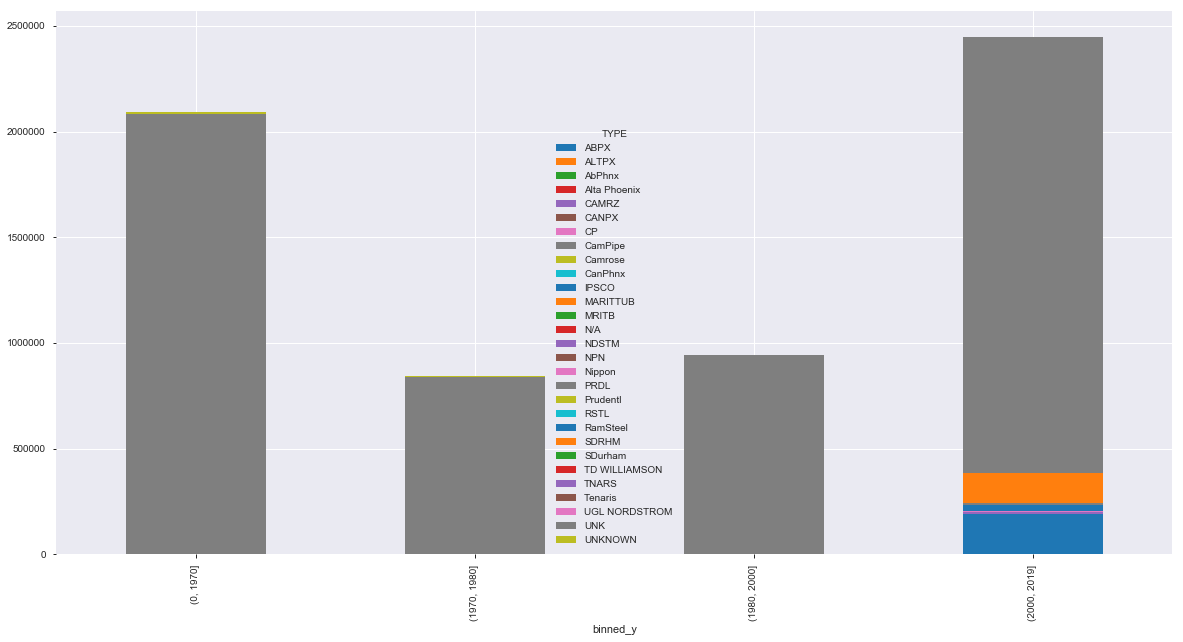

In [325]:
q_manufacturer = """select ld.code as type, ps.* from pipesegment ps
                    inner join listdomain ld on ps.PIPEMANUFACTURERDOMAINID = ld.id"""

manufacturer_df = oracle_sql(q_manufacturer)
manufacturer_df['INSERVICE_YEAR'] = pd.to_datetime(manufacturer_df.PIPEINSERVICEDATE).dt.year

manufacturer_df.assign(LENGTH = lambda x: (x.ENDSTATIONNUM-x.BEGINSTATIONNUM),
                      binned_y = pd.cut(manufacturer_df.INSERVICE_YEAR, bins=[0,1970,1980,2000,2019])).groupby(['binned_y','TYPE']).sum().LENGTH.fillna(0.0).unstack().plot(kind='bar',stacked=True)

In [330]:
B1 = {'landuse':[0.26 ,0.13 ,0.18 ,0.038,
0.03 ,0.03] ,
'class':[0.046,
0.330,
0.190,
0.190,np.nan,np.nan]}
pd.DataFrame(B1).apply(lambda x: x*2)

,landuse,class
0,0.520,0.092
1,0.260,0.660
2,0.360,0.380
3,0.076,0.380
4,0.060,NaN
5,0.060,NaN


In [334]:
%ls "0 Archived RAD Versions"

 Volume in drive Z is Projects
 Volume Serial Number is BC71-F23D

 Directory of Z:\ATCO\ATCO Pipelines\2019-05_RAD Workshop\3_Engineering\Documentation\0 Archived RAD Versions

10/15/2019  08:01 AM    <DIR>          .
10/15/2019  08:01 AM    <DIR>          ..
10/03/2019  12:08 PM         3,024,131 ATCO Draft Gas Transmission Risk Algorithm Document_20191001_AB.docx
10/03/2019  12:08 PM         3,024,120 ATCO Draft Gas Transmission Risk Algorithm Document_20191003_AB.docx
10/07/2019  04:11 PM         3,348,528 ATCO Draft Gas Transmission Risk Algorithm Document_20191007_AB.docx
10/09/2019  08:37 AM         3,356,357 ATCO Draft Gas Transmission Risk Algorithm Document_20191008_1_AB.docx
10/08/2019  09:25 AM         3,349,242 ATCO Draft Gas Transmission Risk Algorithm Document_20191008_AB.docx
10/09/2019  04:24 PM         3,354,381 ATCO Draft Gas Transmission Risk Algorithm Document_20191009_AB.docx
10/11/2019  10:06 AM         3,431,222 ATCO Draft Gas Transmission Risk Algorithm Documen

In [364]:
poe_s = 1.0
poe_n = 1-pow(1-poe_s,1.0/(30/1000.0))
poe_n

1.0

In [366]:
0.999999/(14.3/1000.0)

69.92999999999999

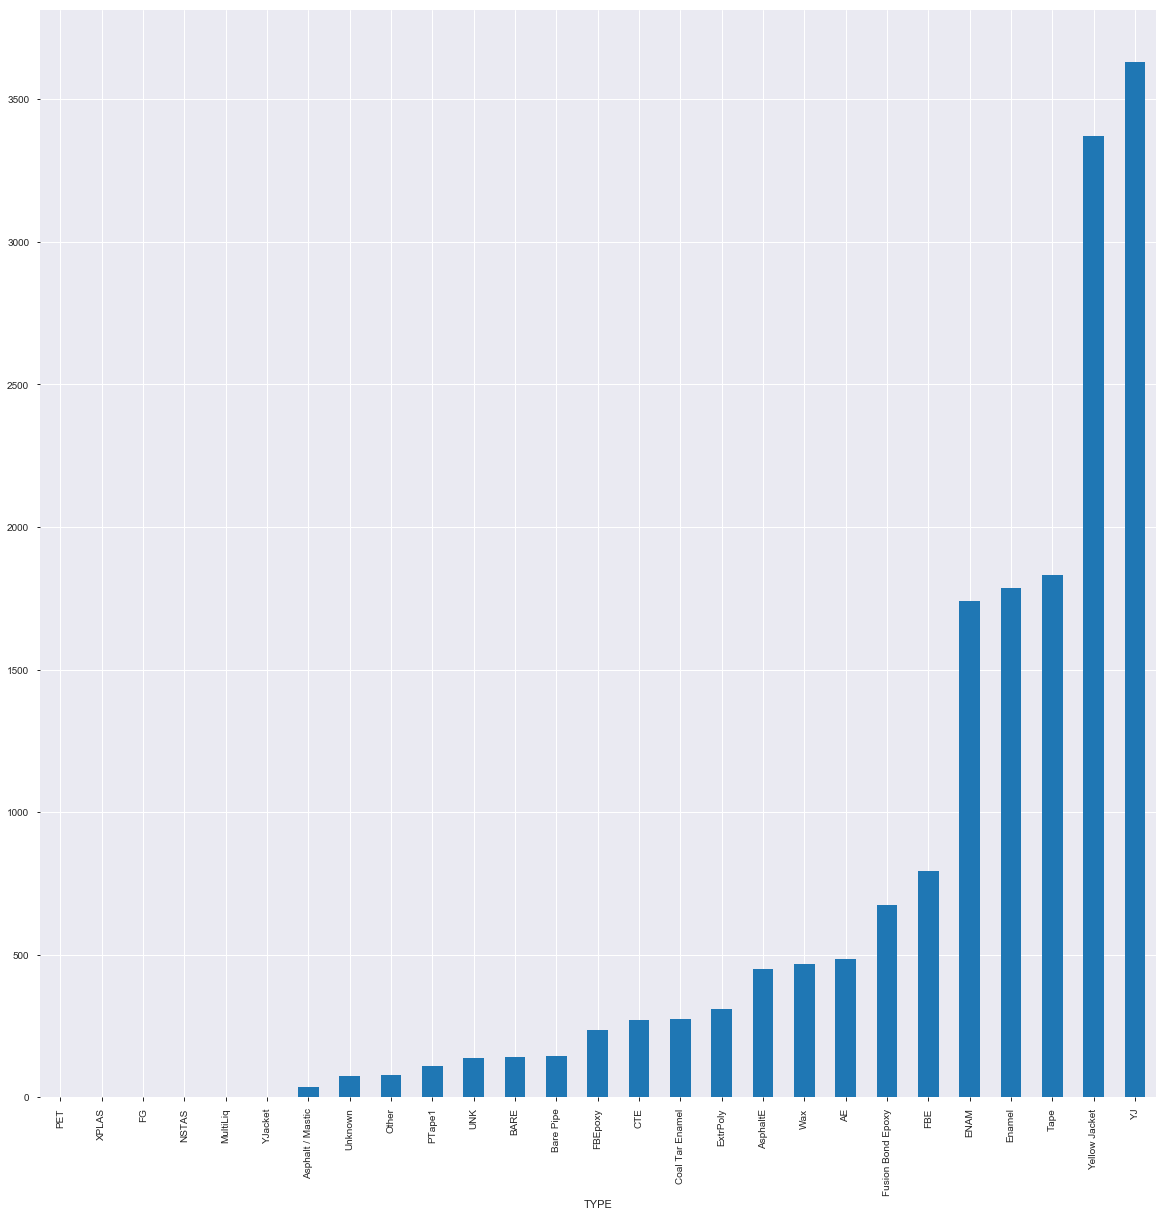

In [16]:
query = """select ld.code as type, c.* from coating c
           join listdomain ld on c.COATINGLINEDOMAINID = ld.id
        """

oracle_sql(query).assign(ds_length=lambda x: (x.ENDSTATIONNUM-x.BEGINSTATIONNUM)/1000.).groupby("TYPE").sum().sort_values("ds_length").ds_length.plot(kind='bar')

In [19]:
q = """select ld.code as type, ss.* from stationseries ss
        join lineloop ll on ll.id = ss.lineloopid
        join listdomain ld on ll.linelooptypeld = ld.id
        """

ssdf = oracle_sql(q)

In [20]:
ssdf

,TYPE,ID,EFFECTIVESTARTDATE,EFFECTIVEENDDATE,LINELOOPID,DISCHARGESUBSYSTEMID,SERIESVALUENUMBER,BEGINSTATIONNUM,ENDSTATIONNUM,LASTMODBYUSERID,LASTMODDATETIME
0,Non-Piggable,23971,2011-11-16,2019-05-15 13:54:09,810008008,810008008,0000007652.0000,0.00,1.000,ATCO_IRASV5_STAGE,2019-05-15 13:54:10
1,Non-Piggable,21953,2011-11-16,2019-05-15 13:54:09,810008009,810008009,0000007653.0000,0.00,1.000,ATCO_IRASV5_STAGE,2019-05-15 13:54:10
2,Piggable,7138,2011-11-16,2019-05-15 13:54:09,810008010,810008010,0076501000.0000,0.00,19759.740,ATCO_IRASV5_STAGE,2019-05-15 13:54:09
3,Non-Piggable,18895,2011-11-16,2019-05-15 13:54:09,810008011,810008011,0000021941.0000,0.00,6.680,ATCO_IRASV5_STAGE,2019-05-15 13:54:10
4,Non-Piggable,804283658,1997-01-01,2019-05-15 13:54:09,810008012,810008012,0000011232.0000,1090.77,1190.600,ATCO_IRASV5_STAGE,2019-05-15 13:54:09
5,Non-Piggable,804306293,2011-11-16,2019-05-15 13:54:09,810008013,810008013,0000000141.0000,6895.90,7634.710,ATCO_IRASV5_STAGE,2019-05-15 13:54:09
6,Non-Piggable,24917,2011-11-16,2019-05-15 13:54:09,810008015,810008015,0000000111.0000,0.00,8.090,ATCO_IRASV5_STAGE,2019-05-15 13:54:09
7,Non-Piggable,24945,2011-11-16,2019-05-15 13:54:09,810008016,810008016,0000000112.0000,0.00,1.360,ATCO_IRASV5_STAGE,2019-05-15 13:54:09
8,Non-Piggable,24948,2011-11-16,2019-05-15 13:54:09,810008017,810008017,0000000113.0000,0.00,1.010,ATCO_IRASV5_STAGE,2019-05-15 13:54:09
9,Non-Piggable,24941,2011-11-16,2019-05-15 13:54:09,810008018,810008018,0000000114.0000,0.00,16.280,ATCO_IRASV5_STAGE,2019-05-15 13:54:09


In [31]:
ssdf.assign(length = lambda x: x.ENDSTATIONNUM-x.BEGINSTATIONNUM)\
.query("EFFECTIVEENDDATE.isnull()")\
.length.sum()

9359848.341

In [23]:
l = 9_359_848.341/1000.

In [25]:
1/(l*1)

0.00010683933794307191

In [26]:
1/(1*30)

0.03333333333333333